In [3]:
using CSV, DataFrames, PyPlot, ScikitLearn, Random

# support vector classifier
@sk_import svm : SVC
# K-folds cross validation
using ScikitLearn.CrossValidation: KFold

## read in the data
The source of the data is [here](https://archive.ics.uci.edu/ml/datasets/Wine).

Each row of `wine_data.csv` represents measurements on a different bottle of wine-- one of two varieties. The three columns are:
* `class`: the label, i.e. what variety/class of wine it is. the label is not explicitly given, but think: Pinot Noir (-1) vs. Syrah (1).
* `alcohol`: the first feature, percent alcohol in the wine
* `malic_acid`: the second feature, malic acid concentration in the wine

In [4]:
df = CSV.read("wine.csv", copycols=true)
first(df, 5)
by(df, :class, nrow)

,class,x1
,Int64,Int64
1,-1,71
2,1,48


## visualize the data

draw a scatter plot of the data scattered in 2D feature space. color each data point by the class label. use hollow circles to help see points that are overlapping.

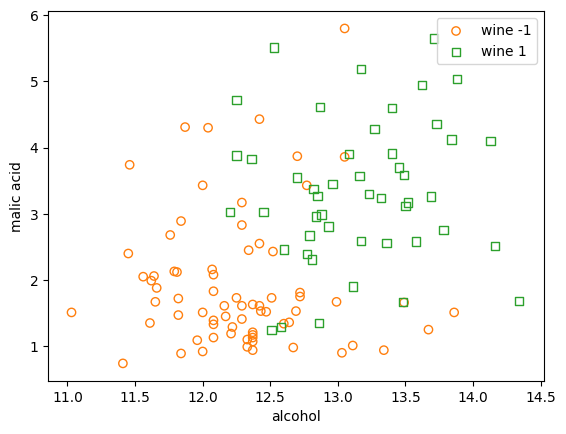

PyObject Text(24.000000000000007, 0.5, 'malic acid')

In [5]:
colors = Dict(-1 => "C1", 1 => "C2")
markers = Dict(-1 => "o", 1 => "s")

figure()
for df_w in groupby(df, :class)
    wine_class = df_w[1, :class]
    scatter(df_w[:, :alcohol], df_w[:, :malic_acid], label="wine $wine_class",
        facecolor="None", edgecolor=colors[wine_class], marker=markers[wine_class])
end
legend()
xlabel("alcohol")
ylabel("malic acid")

## getting data ready for input to scikitlearn

to build a predictive model in scikitlearn:
* construct a feature matrix `X` that has `n_wines` rows and `2` columns (one column for each feature)
* construct a column vector `y` with the labels

loop through the rows of the wine `DataFrame` and populate each entry of the feature matrix `X` and target vector `y` with appropriate values

In [7]:
n_wines = nrow(df)

X = zeros(n_wines, 2)
y = zeros(n_wines)

for (w, wine) in enumerate(eachrow(df))
    X[w, 1] = wine[:alcohol]
    X[w, 2] = wine[:malic_acid]
    y[w] = wine[:class]
end

## training a support vector machine (SVM)

train a support vector machine to classify wines using *all* of the data. evaluate the accuracy on *all* of the data. we'll later show through cross-validation that this is an overestimate of the true accuracy of the SVM classifier on unseen data. use `C=1.0`. use the linear kernel. [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) is the documentation for the `SVC` function (Support Vector Classifier) in scikitlearn.

```julia
# use a linear kernel
clf = SVC(kernel="linear", C=1.0)
```

In [8]:
clf = SVC(kernel="linear", C=1.0)
clf.fit(X, y)
println("accuracy when trained on all data is: ", clf.score(X, y))

accuracy when trained on all data is: 0.8403361344537815


## visualize the decision boundary

draw the decision boundary (in feature space) learned by the SVM trained on test data. Also plot the data in feature space (with the decision boundary) with different colors/symbols for the different classes (exactly as in `# visualize the data`). hint: follow the class notes for k-nearest neighbors, using `contourf`, but this is not the only way.

In [9]:
function draw_decision_boundary(clf)
    alc = range(11.0, stop=14.5, length=150)
    ma = range(0.0, stop=6.0, length=150)
    svm_prediction = zeros(length(ma), length(alc))
    for i = 1:length(alc)
        for j = 1:length(ma)
            x = [alc[i] ma[j]]
            svm_prediction[j, i] = clf.predict(x)[1]
        end
    end
    contourf(alc, ma, svm_prediction, [-1.0, 0.5, 2.0], alpha=0.2, colors=["C1", "C2"])
    xlabel("alcohol")
    ylabel("malic acid")
end

draw_decision_boundary (generic function with 1 method)

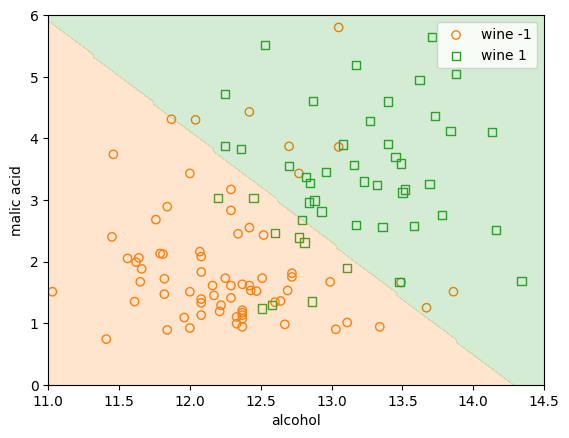

PyObject <matplotlib.legend.Legend object at 0x7feddaf3bc50>

In [10]:
figure()
for df_w in groupby(df, :class)
    wine_class = df_w[1, :class]
    scatter(df_w[:, :alcohol], df_w[:, :malic_acid], label="wine $wine_class",
        facecolor="None", edgecolor=colors[wine_class], marker=markers[wine_class])
end
draw_decision_boundary(clf)
legend()

## $K=5$-fold cross validation
use $K=5$-fold cross validation to:
* choose the optimal `C` parameter in the SVM classifier
* assess the accuracy of the model on unseen data

plot the average test set accuracy (average over the $K$ folds) against the `C` parameter used.

report the best `C` parameter and the associated average test set error (`argmax` might be useful). This test set error is a quality metric of how well the SVM will perform on new, unseen data that is not in the training set. explore the following set of `C` parameters: `c_params = 10.0 .^ range(-3, stop=0, length=25)`. 

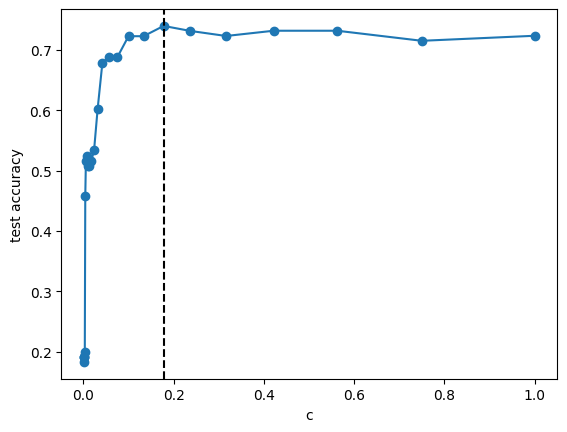

optimal C parameter: 0.1778279410038923
⟨test set accuracy⟩: 0.739855072463768


In [11]:
K = 5 # number of folds
kf = KFold(n_wines, n_folds=K)

c_params = 10.0 .^ range(-3, stop=0, length=25)

test_accuracy = zeros(length(c_params))
for (c, c_param) in enumerate(c_params)
    for (train_ids, test_ids) in kf
        clf = SVC(kernel="linear", C=c_param)
        clf.fit(X[train_ids, :], y[train_ids])
        test_accuracy[c] += clf.score(X[test_ids, :], y[test_ids])
    end
    test_accuracy[c] /= K
end

optimum_c = c_params[argmax(test_accuracy)]

figure()
xlabel("c")
ylabel("test accuracy")
plot(c_params, test_accuracy, marker="o")
axvline(x=optimum_c, color="k", linestyle="--")

println("optimal C parameter: ", optimum_c)
println("⟨test set accuracy⟩: ", maximum(test_accuracy))

the test set accuracy is 10% lower than the training set accuracy! always split your data into test/train or do $K$-fold cross validation! never claim that model performance on training data is representative of the generalization of the model!